In [1]:
import xarray as xr
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image as im
import io
from copy import deepcopy

In [2]:
# load in the raw data
base = '/mnt/data/sonia/occetc/raw'
storms = {}

slp_min = float('Inf')
slp_max = float('-Inf')

shape = (30, 32)
varnames = ['slp', 'fparam', 'thetae']
varranges = {f'{v}_min':float('Inf') for v in varnames} |\
    {f'{v}_max':float('-Inf') for v in varnames}

for month in sorted(os.listdir(base)):
    if month not in set([str(y) for y in range(200609, 201801)]):
        continue
    for nc in sorted(os.listdir(os.path.join(base, month))):
        _, date, hr, lat, lon, vartype, sid, src = nc.split('_')
        assert src == 'MERRA21deg.ncdf'
        
        storm = xr.open_dataset(os.path.join(base, month, nc))
        if storm['latitude'].shape != shape: # ensure it's the right shape
            continue
        
        storms[sid] = storms.get(sid, [])
        storms[sid].append(storm)
        
        for v in varnames:
            if storms[sid][-1][v].min().item() < varranges[f'{v}_min']:
                varranges[f'{v}_min'] = storms[sid][-1][v].min().item()
            if storms[sid][-1][v].max().item() > varranges[f'{v}_max']:
                varranges[f'{v}_max'] = storms[sid][-1][v].max().item()
            
# slp_min = int(slp_min)
# slp_max = int(slp_max)

In [3]:
varranges

{'slp_min': 915.33203125,
 'fparam_min': -2217.1796875,
 'thetae_min': -999.0,
 'slp_max': 1053.2540283203125,
 'fparam_max': 2184.4560546875,
 'thetae_max': 468.8287353515625}

In [4]:
example = list(storms.values())[0][0]
for var in varnames:
    maxdims = len(example[var].dims)
maxdims

3

In [5]:
example

<xarray.Dataset> Size: 124kB
Dimensions:      (stormparam: 5, latitude: 30, longitude: 32,
                  pressurelevel: 25, clustersize: 11, tracklength: 21)
Coordinates:
    longitude    (latitude, longitude) float32 4kB ...
    latitude     (latitude, longitude) float32 4kB ...
Dimensions without coordinates: stormparam, pressurelevel, clustersize,
                                tracklength
Data variables:
    storminfo    (stormparam) float32 20B ...
    slp          (latitude, longitude) float32 4kB 986.9 986.6 ... 1.014e+03
    surfelev     (latitude, longitude) float32 4kB ...
    surfelevstd  (latitude, longitude) float32 4kB ...
    thickness    (latitude, longitude) float32 4kB ...
    fparam       (latitude, longitude) float32 4kB 0.02493 0.7468 ... -999.0
    thetae       (pressurelevel, latitude, longitude) float32 96kB -999.0 ......
    plev         (pressurelevel) float32 100B ...
    clusterlon   (clustersize) float32 44B ...
    clusterlat   (clustersize) float32 44B ...
    clusterf     (clustersize) float32 44B ...
    trackinfo    (tracklength, stormparam) float32 420B ...
Attributes:
    summary:  Theory by Jon Martin and Poushali Ghosh at Univ. Wisconsin. Aut...

## SLP Only

In [5]:
slpset = []
target_len = 8 # how many frames to put in each video

zs = np.full([1, 32], 0)

os.makedirs('/mnt/data/sonia/occetc/out', exist_ok=True)
for sid, logs in storms.items():    
    if len(logs) >= target_len:
        logs = logs[:target_len]
    elif len(logs) < 5: # too short, throw it out
        continue
    else: # too short; need to lengthen
        n = len(logs)
        logs = logs + (target_len-n)*[logs[-1]]
    assert len(logs) == target_len
        
    os.makedirs(f'/mnt/data/sonia/occetc/outxtend/{sid}', exist_ok=True)
        
    for i, log in enumerate(logs):
        log = log['slp'].to_numpy()
        scaled = 255 * (log - slp_min) / (slp_max - slp_min) # scale from 0 to 1
        scaled = np.concatenate([zs, scaled, zs]) # so the frame is 32x32 instead of 30x32 (must be multiples of 8)
        frame = im.fromarray(scaled).convert('RGB')
        frame.save(f'/mnt/data/sonia/occetc/outxtend/{sid}/{i}.png')

/tmp/ipykernel_2715022/388808121.py:21: RuntimeWarning: invalid value encountered in divide
  scaled = 255 * (log - slp_min) / (slp_max - slp_min) # scale from 0 to 1


In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Generate 8 random images (32x32 grayscale)
frames = slpset[2]

# Create a 2-row, 4-column subplot layout
fig, axes = plt.subplots(2, 4, figsize=(12, 6))

# Loop through each frame and plot it
for i, ax in enumerate(axes.flat):
    ax.imshow(frames[i], cmap="viridis")  # Change cmap as needed
    ax.set_title(f"Frame {i+1}")
    ax.axis("off")  # Hide axes for clarity

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


IndexError: list index out of range

In [ ]:
accelerate launch train_svd.py \
    --per_gpu_batch_size=1 --gradient_accumulation_steps=1 \
    --max_train_steps=50 \
    --width=32 \
    --height=32 \
    --checkpointing_steps=25 --checkpoints_total_limit=1 \
    --learning_rate=1e-5 --lr_warmup_steps=0 \
    --seed=123 \
    --mixed_precision="fp16" \
    --validation_steps=50 \
    --num_frames=8

## SLP, F-parameter and Thetae

In [5]:
target_len = 8 # how many frames to put in each video
zs = np.full([1, 32], 0) # just zeros for padding to make a 32x32 square
out_name = 'vars3-25.04.05'

# os.makedirs('/mnt/data/sonia/occetc/out', exist_ok=True)
for sid, logs in storms.items():    
    if len(logs) >= target_len:
        logs = logs[:target_len]
    elif len(logs) < 5: # too short, throw it out
        continue
    else: # too short; need to lengthen
        n = len(logs)
        logs = logs + (target_len-n)*[logs[-1]]
    assert len(logs) == target_len
        
    os.makedirs(f'/mnt/data/sonia/occetc/out/{out_name}/{sid}', exist_ok=True)
        
    for i, log in enumerate(logs):
        os.makedirs(os.path.join('/mnt/data/sonia/occetc', out_name, sid), exist_ok=True)
        scaled = []
        for v in varnames:
            vardata = log[v]
            dims_ordered = [dim for dim in ("latitude", "longitude") if dim in vardata.dims] \
                + [dim for dim in vardata.dims if dim not in ("latitude", "longitude")]
            vardata = vardata.transpose(*dims_ordered).to_numpy()
            if v == 'thetae':
                vardata = vardata[...,0]
            vardata = 255 * (vardata - varranges[f'{v}_min']) / (varranges[f'{v}_max'] - varranges[f'{v}_min'])
            pad_width = [(1,1)] + (vardata.ndim-1) * [(0,0)]
            vardata = np.pad(vardata, pad_width, mode='constant', constant_values=0)
            vardata = vardata.reshape(vardata.shape + (1,) * (maxdims - vardata.ndim))
            scaled.append(vardata)
        matrix = np.concatenate(scaled, axis=2).squeeze().astype(np.uint8)
        # np.save(os.path.join('/mnt/data/sonia/occetc', out_name, sid, f'{i}.npy'), matrix)
        frame = im.fromarray(matrix)#.convert('RGB')
        frame.save(f'/mnt/data/sonia/occetc/{out_name}/{sid}/{i}.png')

In [6]:
matrix.shape

(32, 32, 3)

In [ ]:
accelerate launch train_svd.py \
    --dataset /home/cyclone/train/windmag_io \
    --output_dir /home/sonia/cycloneSVD/out \
    --per_gpu_batch_size=1 --gradient_accumulation_steps=1 \
    --max_train_steps=50 \
    --channels=1 \
    --width=32 \
    --height=32 \
    --checkpointing_steps=25 --checkpoints_total_limit=1 \
    --learning_rate=1e-5 --lr_warmup_steps=0 \
    --seed=123 \
    --mixed_precision="fp16" \
    --validation_steps=50 \
    --num_frames=8

## Visualization

In [102]:
# series of images to plot to video
def dir2vid(vdir):
    name = vdir.split('/')[-1]
    frames = []
    width, height = 1200, 400
    fourcc = cv2.VideoWriter_fourcc(*'mp4v') 
    video = cv2.VideoWriter(f'{name}.mp4', fourcc, 1.5, (width, height))

    for i in range(8):
        img = im.open(os.path.join(exampledir, f'{i}.png'))
        slp, f, thetae = img.split()
        
        #make plot
        fig, axs = plt.subplots(1, 3, figsize=(12, 4))
        axs[0].imshow(slp, cmap='viridis',)# vmin=varranges['slp_min'], vmax=varranges['slp_max'])
        axs[0].set_title('slp')
        axs[1].imshow(f, cmap='viridis',)# vmin=varranges['fparam_min'], vmax=varranges['fparam_max'])
        axs[1].set_title('fparam')
        axs[2].imshow(thetae, cmap='viridis',)# vmin=varranges['thetae_min'], vmax=varranges['thetae_max'])
        axs[2].set_title('thetae')
        
        # convert plot to array
        plt.savefig('tmp.jpeg', format='jpeg')
        img = cv2.imread('tmp.jpeg')
        # video.write(img)
        frames.append(img)
        plt.close()
    black_frame = np.full((height, width, 3), 255, dtype=np.uint8)  
    frames.append(black_frame)
        
    for frame in 4*frames:
        video.write(frame)
    video.release()

In [103]:
# gif to images to video
def gif2vid(gifpath):
    name = gifpath.split('/')[-1].split('.')[0]
    gif = im.open(gifpath)
    rawframes = []

    try:
        while True:
            rawframes.append(gif.copy())
            gif.seek(gif.tell() + 1)
    except EOFError:
        pass  # End of sequence

    width, height = 1200, 400
    fourcc = cv2.VideoWriter_fourcc(*'mp4v') 
    video = cv2.VideoWriter(f'{name}.mp4', fourcc, 1.5, (width, height))

    frames = []
    for rf in rawframes:
        slp, f, thetae = rf.convert("RGB").split()
        
        #make plot
        fig, axs = plt.subplots(1, 3, figsize=(12, 4))
        axs[0].imshow(slp, cmap='viridis',)# vmin=varranges['slp_min'], vmax=varranges['slp_max'])
        axs[0].set_title('slp')
        axs[1].imshow(f, cmap='viridis',)# vmin=varranges['fparam_min'], vmax=varranges['fparam_max'])
        axs[1].set_title('fparam')
        axs[2].imshow(thetae, cmap='viridis',)# vmin=varranges['thetae_min'], vmax=varranges['thetae_max'])
        axs[2].set_title('thetae')
        
        # convert plot to array
        plt.savefig('tmp.jpeg', format='jpeg')
        img = cv2.imread('tmp.jpeg')
        # video.write(img)
        frames.append(img)
        plt.close()
    black_frame = np.full((height, width, 3), 255, dtype=np.uint8)  
    frames.append(black_frame)
        
    for frame in 4*frames:
        video.write(frame)
    video.release()

In [104]:
vdirs = ['/mnt/data/sonia/occetc/vars3-25.04.05/20060903061395011550',
         '/mnt/data/sonia/occetc/vars3-25.04.05/20061003001350007350',
         '/mnt/data/sonia/occetc/vars3-25.04.05/20070314120330029700',
         '/mnt/data/sonia/occetc/vars3-25.04.05/20080119120585028200',
         '/mnt/data/sonia/occetc/vars3-25.04.05/20081228181485026400']
for vdir in vdirs:
    dir2vid(vdir)

In [105]:
gifpaths = ['/mnt/data/sonia/svd/outputs/validation_images/step_50000_val_img_0.gif',
            '/mnt/data/sonia/svd/outputs/validation_images/step_40000_val_img_0.gif',
            '/mnt/data/sonia/svd/outputs/validation_images/step_30000_val_img_0.gif',
            '/mnt/data/sonia/svd/outputs/validation_images/step_20000_val_img_0.gif',
            '/mnt/data/sonia/svd/outputs/validation_images/step_10000_val_img_0.gif']
for gpath in gifpaths:
    gif2vid(gpath)

{'video_found': True, 'audio_found': False, 'metadata': {'major_brand': 'isom', 'minor_version': '512', 'compatible_brands': 'isomiso2mp41', 'encoder': 'Lavf61.7.100'}, 'inputs': [{'streams': [{'input_number': 0, 'stream_number': 0, 'stream_type': 'video', 'language': None, 'default': True, 'size': [1200, 400], 'bitrate': 172, 'fps': 1.5, 'codec_name': 'mpeg4', 'profile': '(Simple Profile)', 'metadata': {'Metadata': '', 'handler_name': 'VideoHandler', 'vendor_id': '[0][0][0][0]'}}], 'input_number': 0}], 'duration': 24.0, 'bitrate': 172, 'start': 0.0, 'default_video_input_number': 0, 'default_video_stream_number': 0, 'video_codec_name': 'mpeg4', 'video_profile': '(Simple Profile)', 'video_size': [1200, 400], 'video_bitrate': 172, 'video_fps': 1.5, 'video_duration': 24.0, 'video_n_frames': 36}
/mnt/data/sonia/miniconda3/envs/ccri/lib/python3.12/site-packages/imageio_ffmpeg/binaries/ffmpeg-linux-x86_64-v7.0.2 -i step_50000_val_img_0.mp4 -loglevel error -f image2pipe -vf scale=1200:400 -sw

frame_index:   0%|          | 0/36 [00:00<?, ?it/s, now=None]

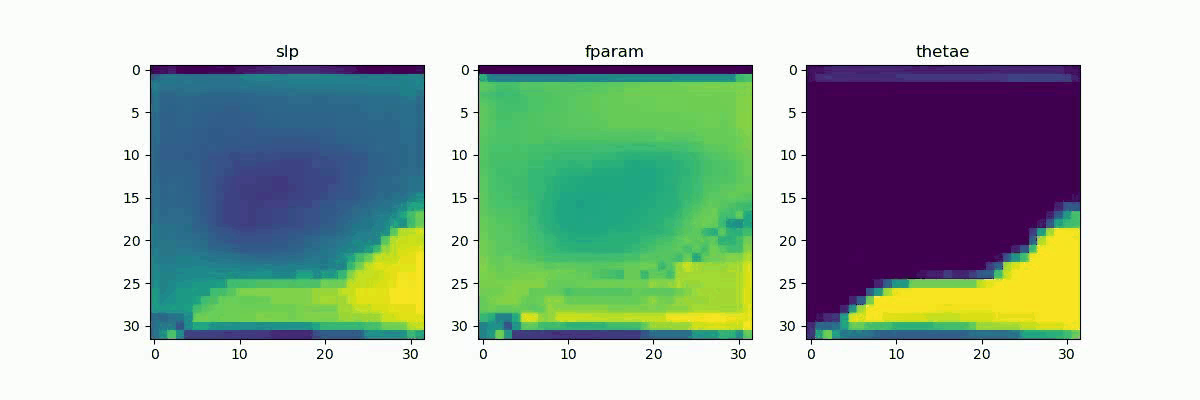

In [85]:
from IPython.display import Image
from moviepy import VideoFileClip
clip = VideoFileClip(f"{name}.mp4")
clip.write_gif(f"{name}.gif")
Image(f"{name}.gif")